In [1]:
import sys
sys.path.append('/home/simone/Desktop/NLFF/Experiments/cumulativeReturnPeper')



import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from math import sqrt
import keras
from keras import backend as K
from keras.models import Sequential,model_from_json
from keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from keras.constraints import max_norm
from keras import optimizers,regularizers
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.optimizers import Adam
from keras.losses import binary_crossentropy,mean_squared_error

from technicalSignals import Indicators





# #CPU RUN
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

/home/simone/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tickers=['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX']
TREND_WINDOWs = [(-48,0),(-35,0),(-28,0),(-7,0),(-1,0),(1,2),(1,8),(1,29),(1,36),(1,50)]
TREND_WINDOWs = [(1,29),(1,36),(1,50)]
kind_of_dataset = 'AffectiveSpace'
NN_INPUT_DIM = 717


In [3]:
class DatasetManager:
    def __init__(self):
        X_raw = None
        Y_raw = None
        Y = None
        X = None
    
    def load_dataset(self, ticker, kind, technicalFeatures=False):
        types = {'Summary': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/',
            'AffectiveSpace': '/home/simone/Desktop/NLFF/AffectiveSpace/Aggregated_AffectSummary_dataset/',
            'Title': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentTitleAggregatedHourly/',
            'Senticnet':''}
        news =  pd.read_csv(types[kind]+ticker+'.csv')
        price = pd.read_csv('/home/simone/Desktop/NLFF/indexes/indexes'+ticker+'.csv')
        price = price.rename(index=str, columns={"date": "DATE"})
        news = news.rename(index=str, columns={"initTime": "DATE"})
        news = news.drop(['Unnamed: 0'], axis=1)
        news['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in news['DATE']]
        # This datased is already GMT+0
        price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
        if(technicalFeatures):
            price['mom_30'] = Indicators.momentum(price, 30)
            price['mom_50'] = Indicators.momentum(price, 50)
            price['mom_100'] = Indicators.momentum(price, 100)
            price['mom_150'] = Indicators.momentum(price, 150)
            price['SMA_30'] = Indicators.SMA(price, 30)
            price['SMA_50'] = Indicators.SMA(price, 50)
            price['SMA_100'] = Indicators.SMA(price, 100)
            price['SMA_150'] = Indicators.SMA(price, 150)
            price['in_BBands'] = Indicators.inBBands(price)
            price['eccessVolumes'] = Indicators.eccessOfVolumes(price)


        #ALLIGNMENT
        initDate = max(news['DATE'][0], datetime(2017, 5, 22, 0, 0, 0))
        finalDate = min(news['DATE'][len(news)-1],datetime(2018, 6, 20, 0, 0, 0))
        news.drop(news[news.DATE > finalDate].index, inplace=True)
        news.drop(news[news.DATE < initDate].index, inplace=True)
        news = news.reset_index(drop=True)
        price.drop(price[price.DATE > finalDate].index, inplace=True)
        price.drop(price[price.DATE < initDate].index, inplace=True)
        price = price.reset_index(drop=True)
        assert len(price) == len(news)
        # FEATURES
        sentiment = news.drop(['DATE'], axis=1)
        X = sentiment
        for window in [5,10,15,20,30,50]:
            temp = sentiment.rolling(window).mean()
            temp.columns = temp.columns +'_'+str(window)
            X = pd.concat([X, temp],axis=1)
        if(technicalFeatures):   
            technical_features = ['mom_30','mom_50','mom_100','mom_150',
                              'SMA_30','SMA_50','SMA_100','SMA_150','in_BBands', 'eccessVolumes']   
            X = pd.concat([X, price[technical_features]],axis=1)
            
        #NORMALIZATION:
        min_max_scaler = preprocessing.MinMaxScaler()
        X = np.nan_to_num(np.asarray(X, dtype=float))
        X = np.asarray(min_max_scaler.fit_transform(X))
        self.X_raw = X
        self.Y_raw = price

    def get_dataset_for_trend(self, init, finish, perc_train = 0.7):
        y = list()
        x = list()
        dates = list()
        price = self.Y_raw
        for i in range(abs(init),len(price)-finish):
            cumulative_return =  (price.iloc[i+finish]['open']-price.iloc[i+init]['open'])/price.iloc[i+init]['open']
            y.append(cumulative_return)
            dates.append(price.iloc[i]['DATE'])
            x.append(self.X_raw[i])
        
        #y = self.normalize(np.array(y))
        y = np.array(y)
        x = np.array(x)
        self.X = x
        self.Y = y
        nt=math.ceil(len(x)*perc_train)
        x_tv = x[:nt]
        y_tv = y[:nt]
        x_test = x[nt:]
        y_test = y[nt:]
        dates_test = dates[nt:]
        return (x_tv,y_tv),(x_test,y_test),dates_test
    
    def normalize(self, values):
        m = min(values)
        M = max(values)
        values = 2*(values-m)/(M-m)-1
        return values
    
    def get_dataset_for_trend_all_tickers(self, init, finish,kind, perc_train = 0.7, technicalFeatures=False):
        x_tv_all = []
        y_tv_all = []
        x_test_all = []
        y_test_all = []
        dates_test_prev = None
        for ticker in tickers:
            self.load_dataset(ticker, kind, technicalFeatures)
            (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
            if(dates_test_prev):
                assert dates_test == dates_test_prev #I'm not secure about this constraint but otherwise which dates I will output?
            x_tv_all += x_tv.tolist()
            y_tv_all += y_tv.tolist()
            x_test_all += x_test.tolist()
            y_test_all += y_test.tolist()
        x_tv_all = np.asarray(x_tv_all)
        y_tv_all = np.asarray(y_tv_all)
        x_test_all = np.asarray(x_test_all)
        y_test_all = np.asarray(y_test_all)
        return (x_tv_all,y_tv_all),(x_test_all,y_test_all), dates_test

In [4]:
def weighted_MSE(y_true, y_pred):
    weights = K.pow(y_true,2)
    m = K.min(weights)
    M = K.max(weights)
    weights = (weights-m)/(M-m)
    return  K.mean(K.pow(y_true - y_pred, 2)*weights)

def get_pretrained_model(init, finish):
    json_file = open('pretraining_weights/nn_model_'+str(init)+'_'+str(finish)+'_linW.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    nn_model = model_from_json(loaded_model_json)
    nn_model.load_weights('pretraining_weights/nn_model_pretrained_weights_all_tickers_REGR_'+str(init)+'_'+str(finish)+'_linW.h5')
    #All layers not trainable except last one
    i=0
    while nn_model.get_layer(index=i) != nn_model.get_layer(index=-1):
        nn_model.get_layer(index=i).trainable = False
        i +=1
    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    nn_model.compile(optimizer=opt,loss='mse', metrics=[weighted_MSE])
    return nn_model


def reset_weights(model):
    session=K.get_session()
    for layer in model.layers:
        if(hasattr(layer,'kernel_initializer')):
            layer.kernel.initializer.run(session=session)
            
def plot_hystory(history,y_pred,y_test,l2,drop,n_units):
    f, axarr = plt.subplots(2)
    f.set_figheight(7)
    f.set_figwidth(10)
    axarr[0].plot(y_test,'g', label='y_test')
    axarr[0].plot(y_pred,'r', label='y_pred')
    if history:
        axarr[1].semilogy(history.history['loss'],'g--',label='loss_train')
        axarr[1].semilogy(history.history['val_loss'],'r--',label='loss_val')
        axarr[1].semilogy(history.history['val_weighted_MSE'],'b:',label='loss_val_WITH_W')
        axarr[1].semilogy(history.history['weighted_MSE'],'g:',label='loss_WITH_W')
        print('Min val loss: ', min(history.history['val_loss']))
        print('Val loss: ', history.history['val_loss'][-1])
    axarr[1].legend()   
    axarr[0].legend()   
    axarr[0].set_title('l2: '+str(l2)+' drop: '+str(drop)+' n_units: '+str(n_units))   
    plt.show()


            
            
def best_num_epoch(x_tv,y_tv):
    nn_model = get_pretrained_model(init, finish)
    trainpoint=math.floor(len(x_tv)*0.7)
    x_train=x_tv[0:trainpoint]
    y_train=y_tv[0:trainpoint]
    x_val=x_tv[trainpoint:]
    y_val=y_tv[trainpoint:]
    weights = np.power(y_train,2)
    m = min(weights)
    M = max(weights)
    weights = (weights-m)/(M-m)
    history = nn_model.fit(x_train, y_train, epochs = 200,batch_size =256, verbose=0, 
                           validation_data=(x_val, y_val),shuffle=True,
                           sample_weight = weights)
    best_epoch = np.argmin(np.convolve(history.history['val_weighted_MSE'], np.ones((4,))/4, mode='valid'))
                
    return best_epoch




====================  AAPL  trend:  1   29  ==================== 




No handles with labels found to put in legend.


Epochs:  0
==== Test ===


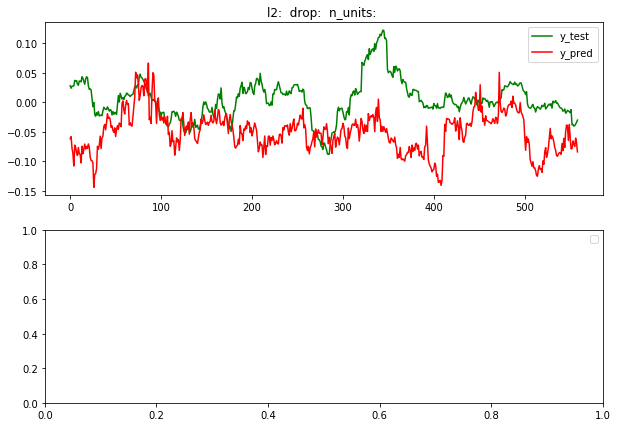




====================  AAPL  trend:  1   36  ==================== 


Epochs:  154
==== Test ===
Min val loss:  0.0030956670143006157
Val loss:  0.0031634747130960175


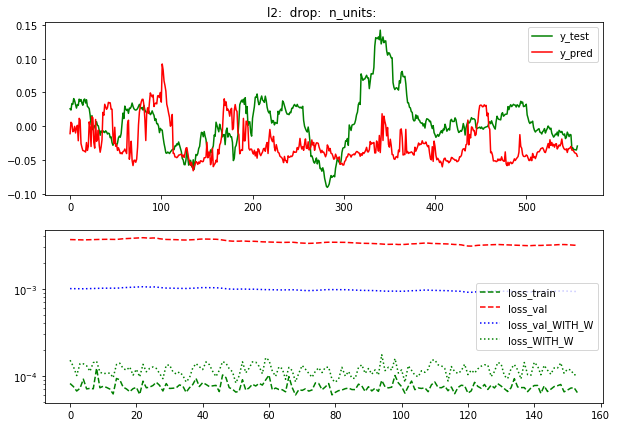




====================  AAPL  trend:  1   50  ==================== 


Epochs:  0


No handles with labels found to put in legend.


==== Test ===


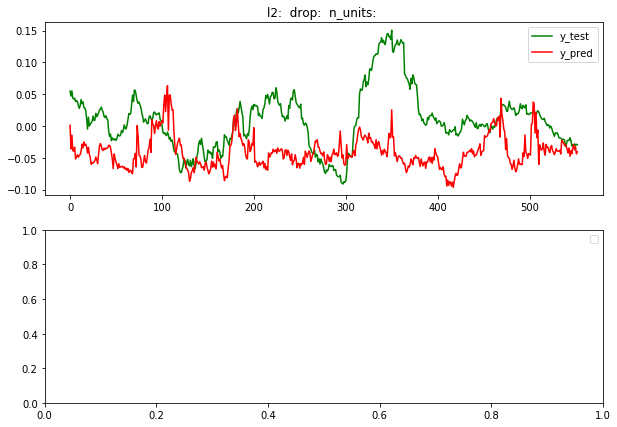




====================  AMZN  trend:  1   29  ==================== 


Epochs:  54
==== Test ===
Min val loss:  0.005403602146751819
Val loss:  0.00656097539415673


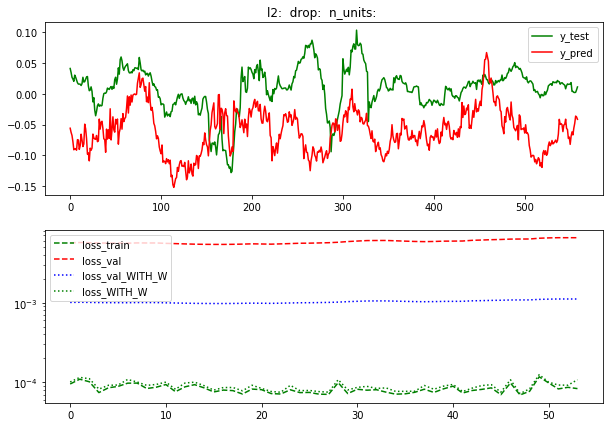




====================  AMZN  trend:  1   36  ==================== 


Epochs:  139
==== Test ===
Min val loss:  0.003870969055524795
Val loss:  0.0043661243924319314


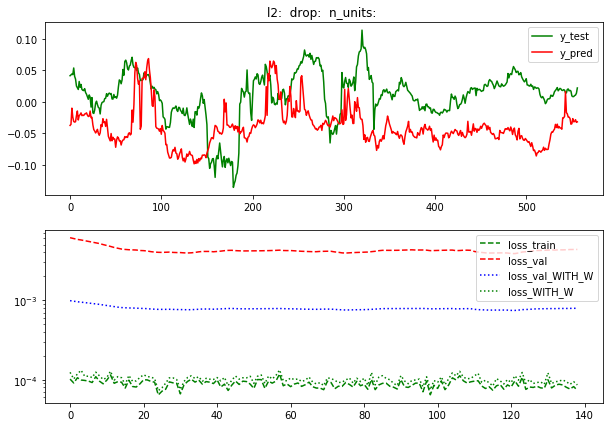




====================  AMZN  trend:  1   50  ==================== 


Epochs:  17
==== Test ===
Min val loss:  0.003993630897637733
Val loss:  0.004138645301716129


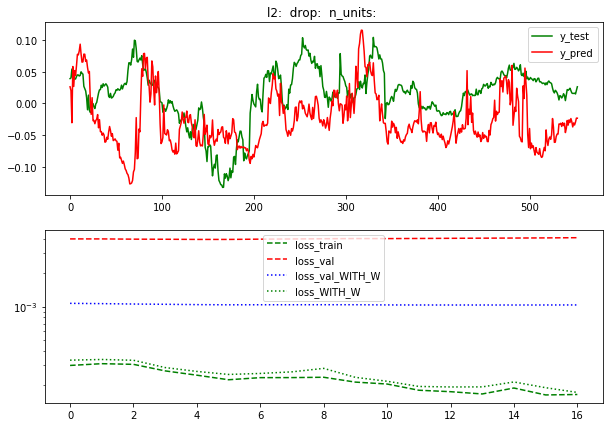




====================  GOOGL  trend:  1   29  ==================== 


Epochs:  177
==== Test ===
Min val loss:  0.004890409805553704
Val loss:  0.007557486898677294


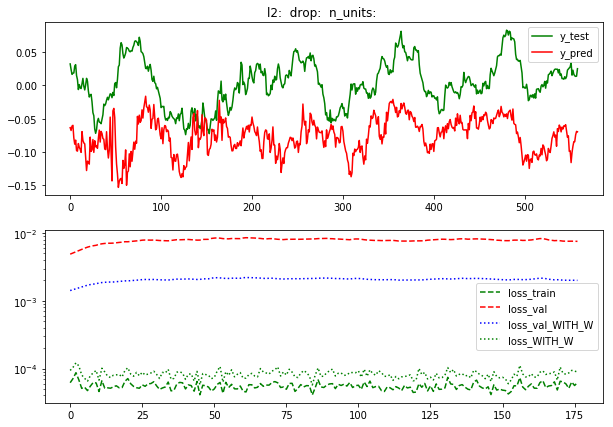




====================  GOOGL  trend:  1   36  ==================== 


Epochs:  140
==== Test ===
Min val loss:  0.0036026722395414725
Val loss:  0.004450772271142133


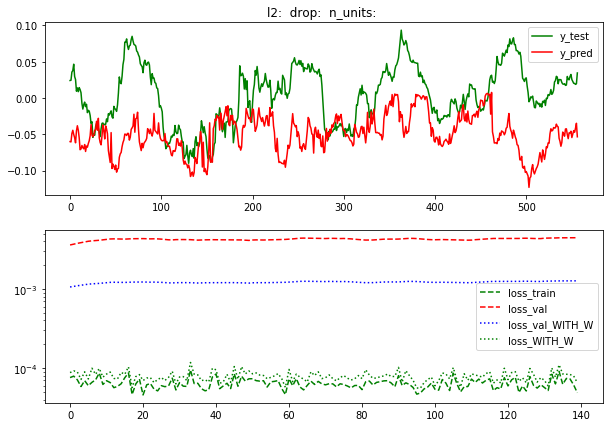




====================  GOOGL  trend:  1   50  ==================== 


Epochs:  98
==== Test ===
Min val loss:  0.003859795203893892
Val loss:  0.004331837755595932


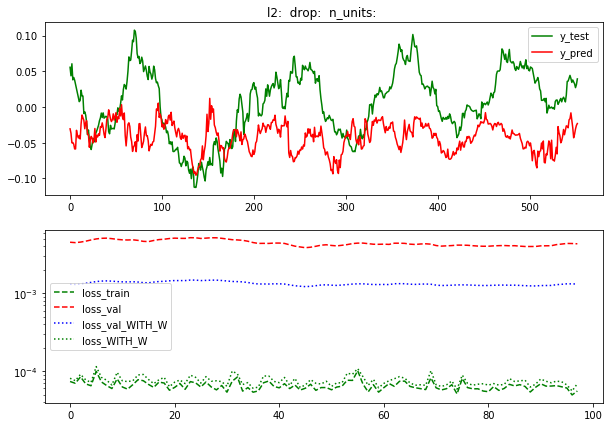




====================  MSFT  trend:  1   29  ==================== 


Epochs:  148
==== Test ===
Min val loss:  0.003683532687522178
Val loss:  0.003895033485995862


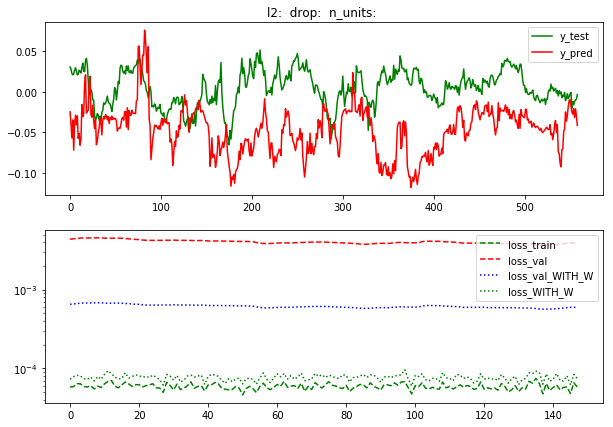




====================  MSFT  trend:  1   36  ==================== 


Epochs:  195
==== Test ===
Min val loss:  0.002732757472682283
Val loss:  0.002930361109984708


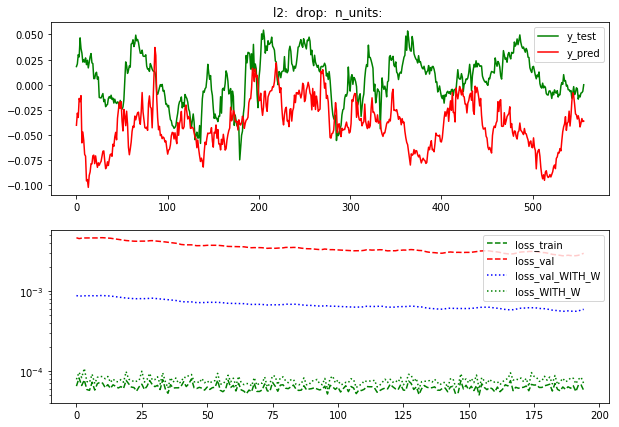




====================  MSFT  trend:  1   50  ==================== 


Epochs:  34
==== Test ===
Min val loss:  0.003928787989464418
Val loss:  0.003928787989464418


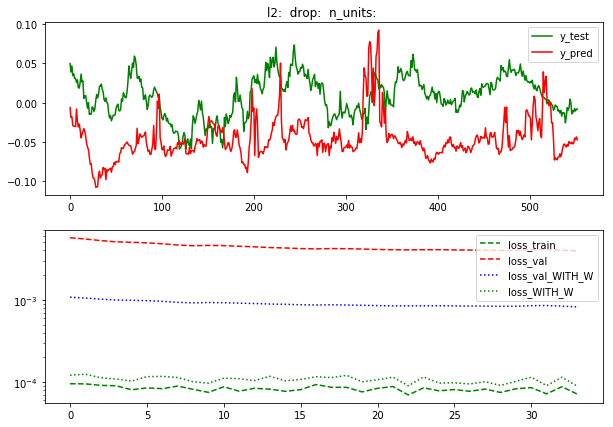




====================  FB  trend:  1   29  ==================== 


Epochs:  181
==== Test ===
Min val loss:  0.002603875026223458
Val loss:  0.003003272920187183


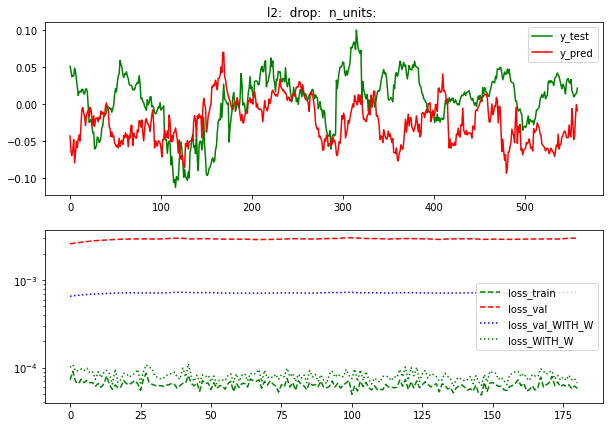




====================  FB  trend:  1   36  ==================== 


Epochs:  86
==== Test ===
Min val loss:  0.004928364537161385
Val loss:  0.005979751163167307


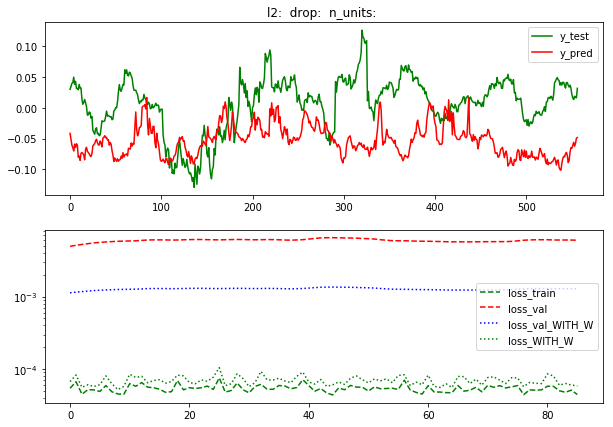




====================  FB  trend:  1   50  ==================== 


Epochs:  25
==== Test ===
Min val loss:  0.007057573991553154
Val loss:  0.007577866614774328


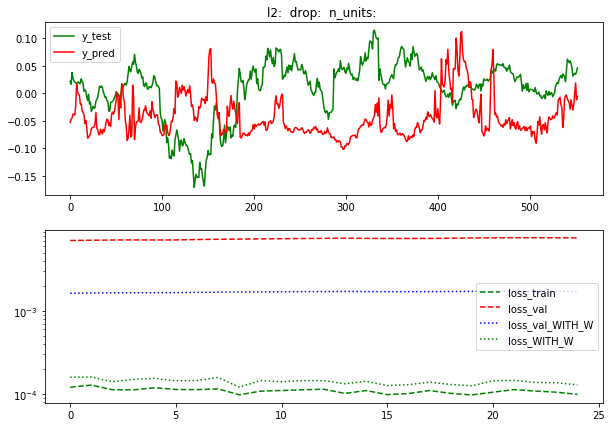




====================  INTC  trend:  1   29  ==================== 


Epochs:  170
==== Test ===
Min val loss:  0.00221552268505323
Val loss:  0.00263500598480855


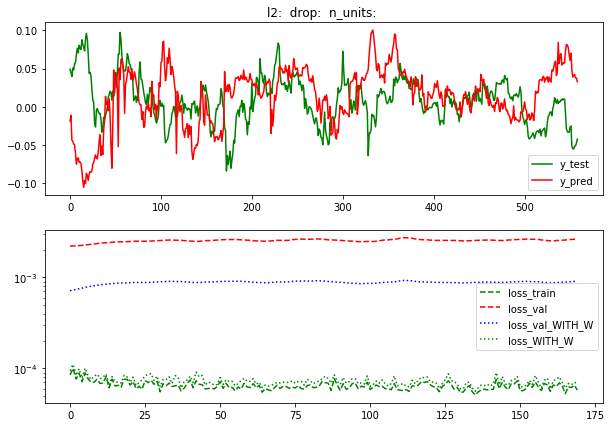




====================  INTC  trend:  1   36  ==================== 


Epochs:  191
==== Test ===
Min val loss:  0.0032335159517624004
Val loss:  0.004593255228648895


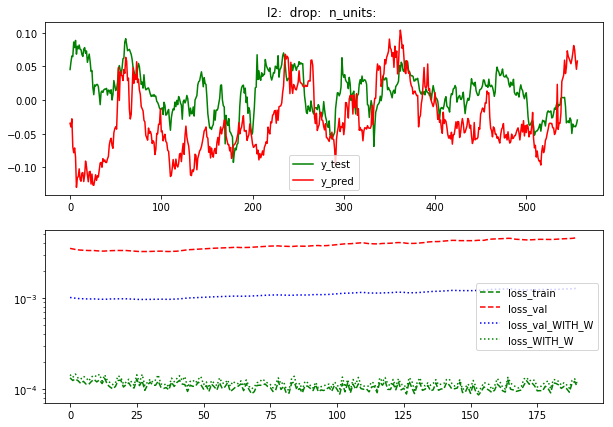




====================  INTC  trend:  1   50  ==================== 


Epochs:  2
==== Test ===
Min val loss:  0.0020221566308161773
Val loss:  0.0020221566308161773


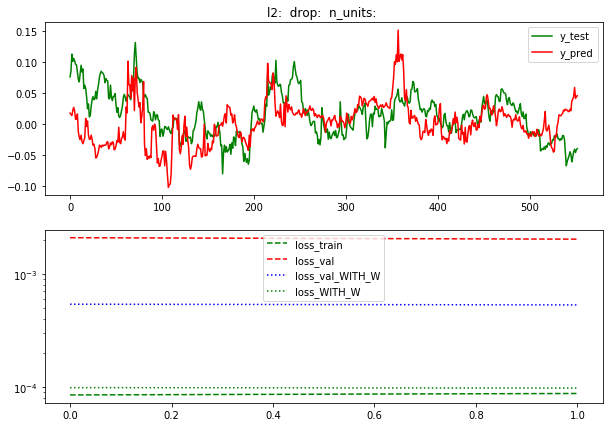




====================  CSCO  trend:  1   29  ==================== 


Epochs:  183
==== Test ===
Min val loss:  0.0018083333295615047
Val loss:  0.0018810414288889397


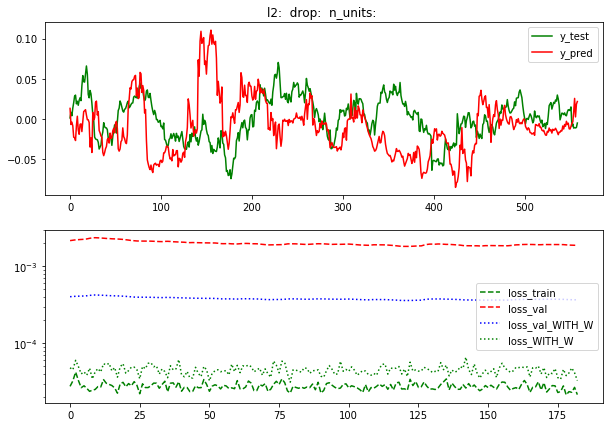




====================  CSCO  trend:  1   36  ==================== 


Epochs:  93
==== Test ===
Min val loss:  0.002751476569413153
Val loss:  0.002751476569413153


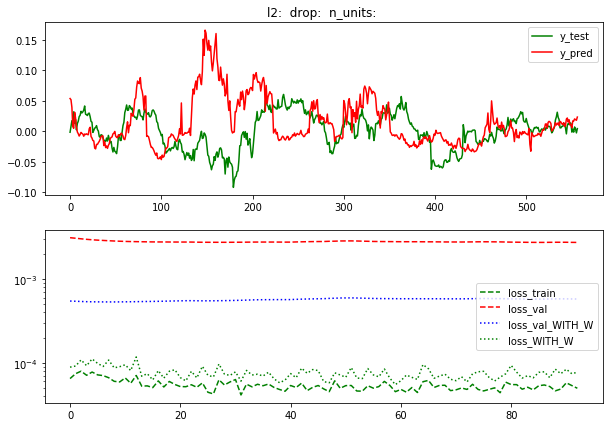




====================  CSCO  trend:  1   50  ==================== 


Epochs:  196
==== Test ===
Min val loss:  0.0018315510761167915
Val loss:  0.0019039560699242607


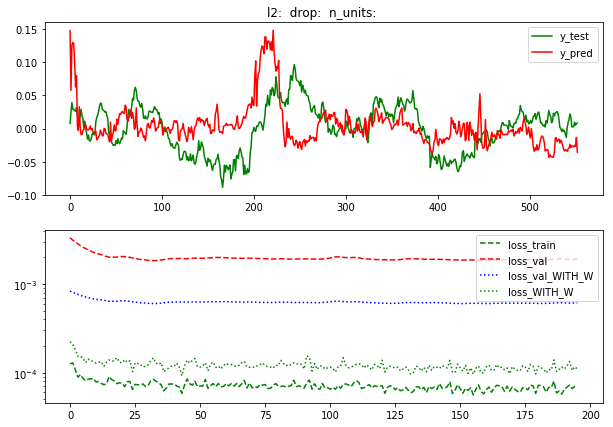




====================  CMCSA  trend:  1   29  ==================== 


Epochs:  0


No handles with labels found to put in legend.


==== Test ===


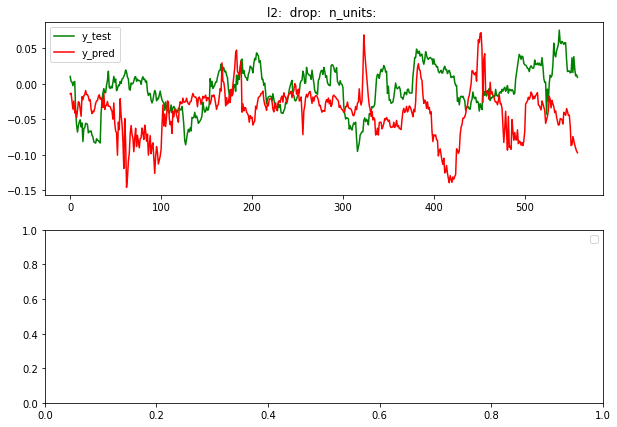




====================  CMCSA  trend:  1   36  ==================== 


Epochs:  0


No handles with labels found to put in legend.


==== Test ===


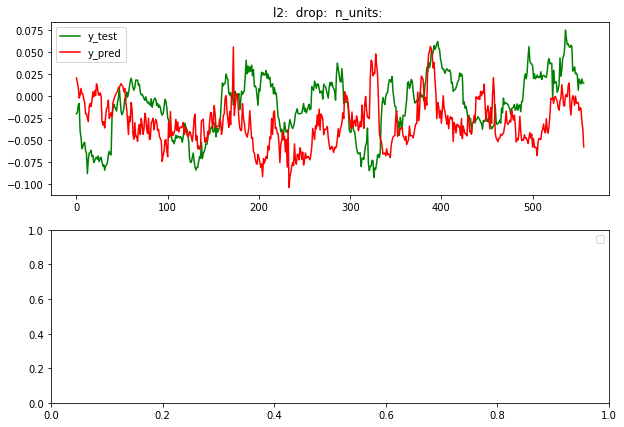




====================  CMCSA  trend:  1   50  ==================== 


Epochs:  0


No handles with labels found to put in legend.


==== Test ===


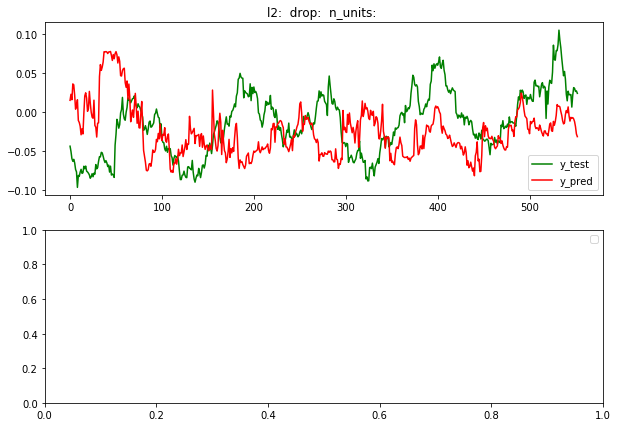




====================  NVDA  trend:  1   29  ==================== 


Epochs:  134
==== Test ===
Min val loss:  0.0027546537442346085
Val loss:  0.0032353081905169743


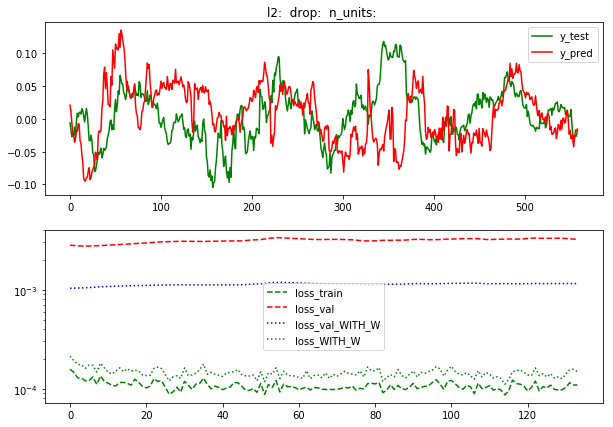




====================  NVDA  trend:  1   36  ==================== 


Epochs:  14
==== Test ===
Min val loss:  0.004563781796892707
Val loss:  0.004639514359516799


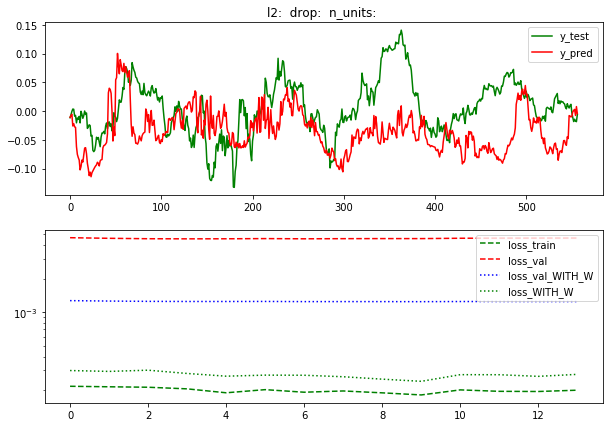




====================  NVDA  trend:  1   50  ==================== 


Epochs:  108
==== Test ===
Min val loss:  0.004859855504425253
Val loss:  0.005651821779797887


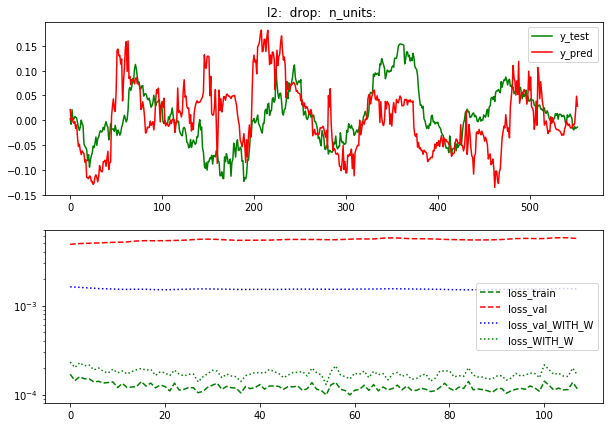




====================  NFLX  trend:  1   29  ==================== 


Epochs:  144
==== Test ===
Min val loss:  0.004991572787602014
Val loss:  0.005913329226579617


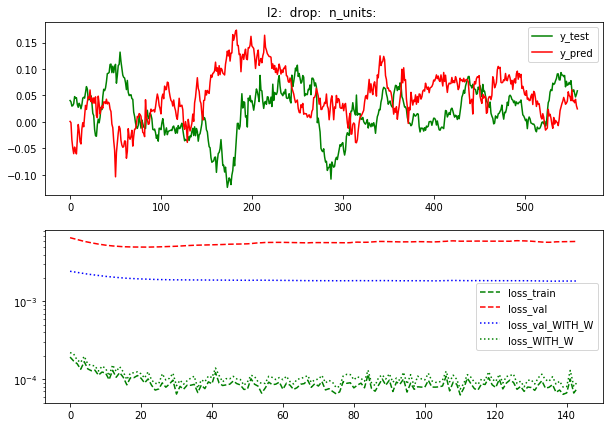




====================  NFLX  trend:  1   36  ==================== 


Epochs:  91
==== Test ===
Min val loss:  0.00443227595818535
Val loss:  0.006153113879196519


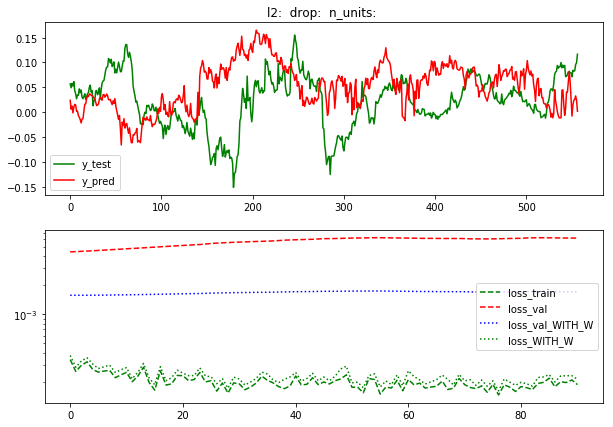




====================  NFLX  trend:  1   50  ==================== 


Epochs:  0


No handles with labels found to put in legend.


==== Test ===


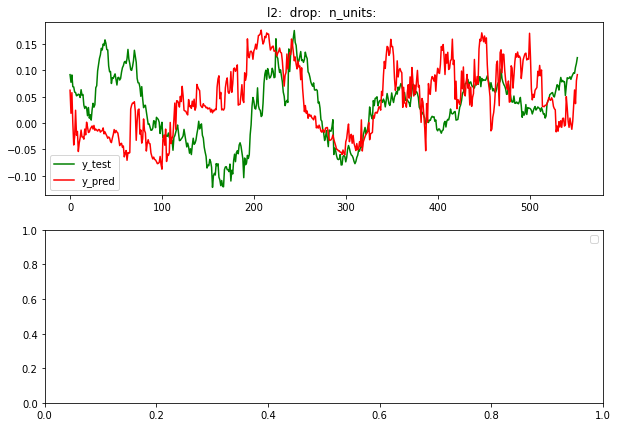

In [5]:
for ticker in tickers:
    for (init, finish) in TREND_WINDOWs:
        print('\n\n\n==================== ',ticker,' trend: ',init,' ',finish, ' ==================== \n\n')
        ds = DatasetManager()
        ds.load_dataset(ticker = ticker, kind = kind_of_dataset, technicalFeatures=True)
        (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
        nn_model = get_pretrained_model(init, finish)
        best_epochs = best_num_epoch(x_tv,y_tv)
        print('Epochs: ',best_epochs)
        if best_epochs > 0:
            weights = np.power(y_tv,2)
            m = min(weights)
            M = max(weights)
            weights = (weights-m)/(M-m)
            best_num_epoch(x_tv,y_tv)
            history = nn_model.fit(x_tv, y_tv, epochs = best_epochs, batch_size =256, verbose=0,
                                   validation_data=(x_test, y_test),shuffle=True, sample_weight = weights)
        else:
            history = None
        y_pred = nn_model.predict(x_test, batch_size=256, verbose=0)
        nn_model.save_weights('fineTuning_weights/nn_model_finetuned_weights_'+ticker+'_REGR_'+str(init)+'_'+str(finish)+'_linW.h5')   
        np.savetxt('test_predictions/'+ticker+'_'+str(init)+'_'+str(finish)+'.csv', y_pred, delimiter=",")

        print('==== Test ===')
        plot_hystory(history,y_pred,y_test,'','','')  
        

AAPL   1   2


/home/simone/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


AAPL   1   8
AAPL   1   29
AAPL   1   36
AAPL   1   50
AMZN   1   2
AMZN   1   8
AMZN   1   29
AMZN   1   36
AMZN   1   50
GOOGL   1   2
GOOGL   1   8
GOOGL   1   29
GOOGL   1   36
GOOGL   1   50
MSFT   1   2
MSFT   1   8
MSFT   1   29
MSFT   1   36
MSFT   1   50
FB   1   2
FB   1   8
FB   1   29
FB   1   36
FB   1   50
INTC   1   2
INTC   1   8
INTC   1   29
INTC   1   36
INTC   1   50
CSCO   1   2
CSCO   1   8
CSCO   1   29
CSCO   1   36
CSCO   1   50
CMCSA   1   2
CMCSA   1   8
CMCSA   1   29
CMCSA   1   36
CMCSA   1   50
NVDA   1   2
NVDA   1   8
NVDA   1   29
NVDA   1   36
NVDA   1   50
NFLX   1   2
NFLX   1   8
NFLX   1   29
NFLX   1   36
NFLX   1   50


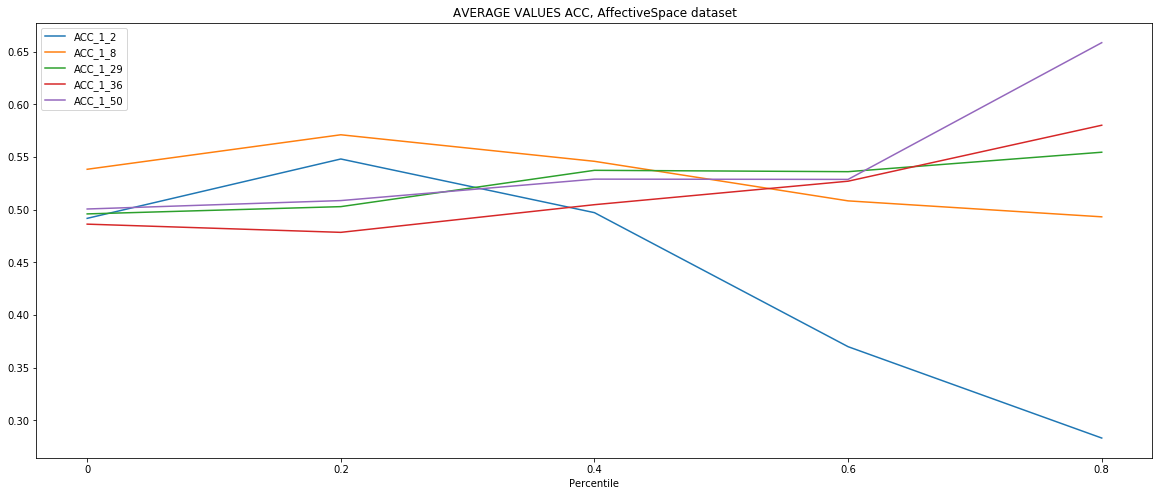

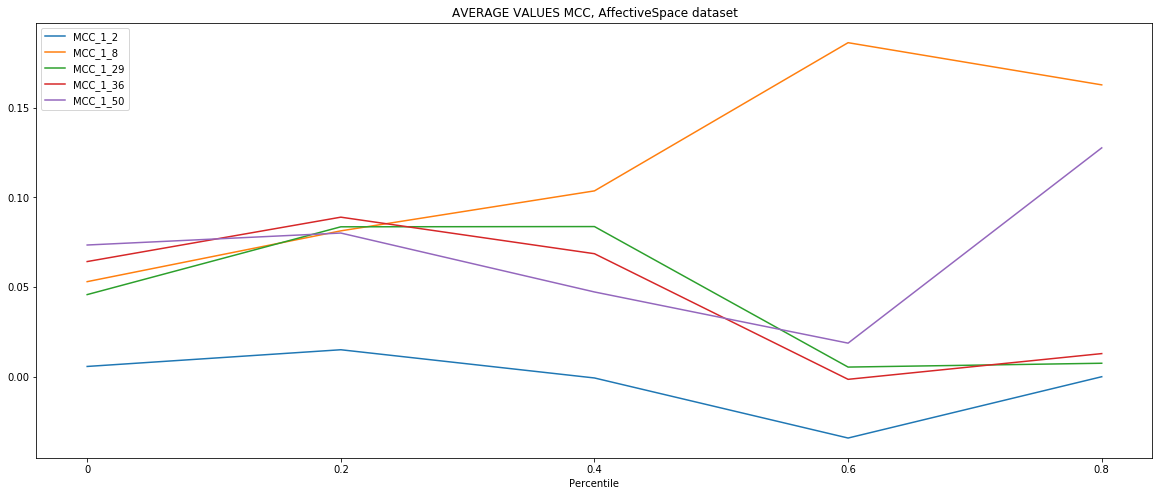

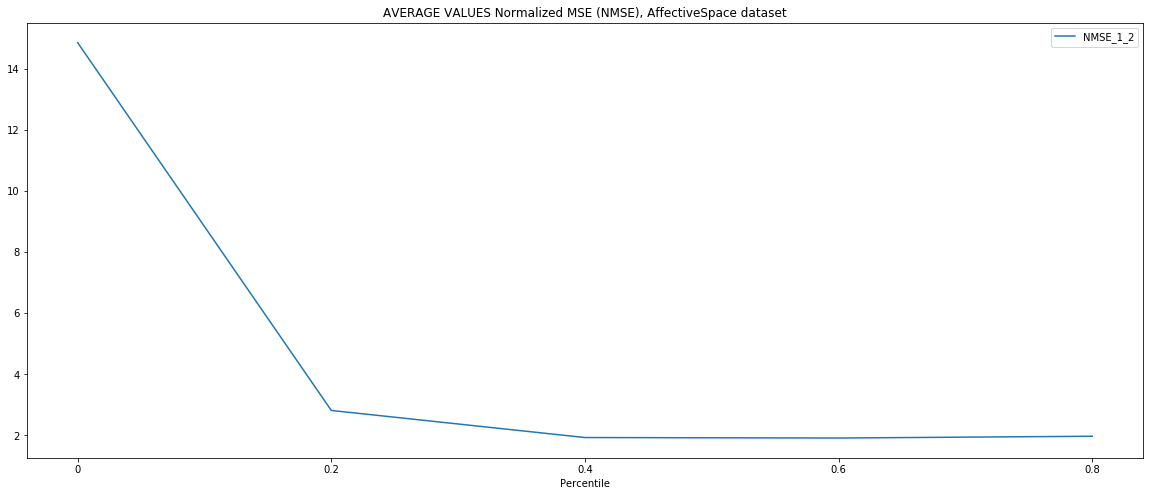

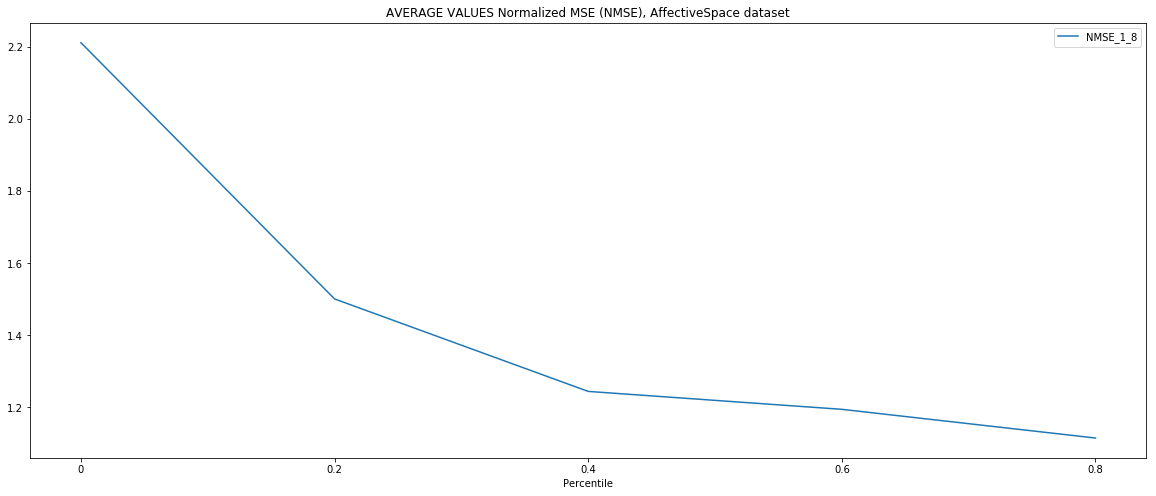

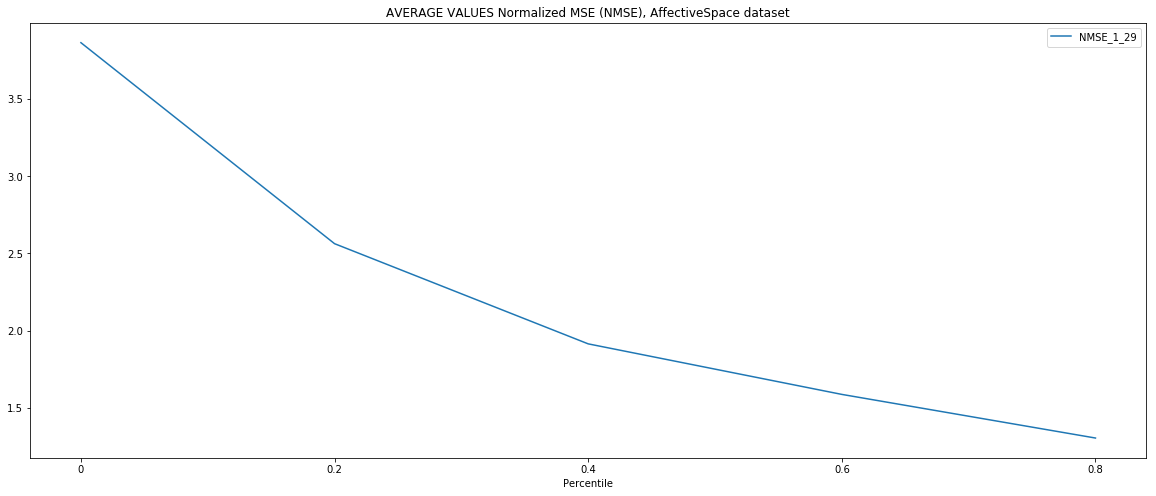

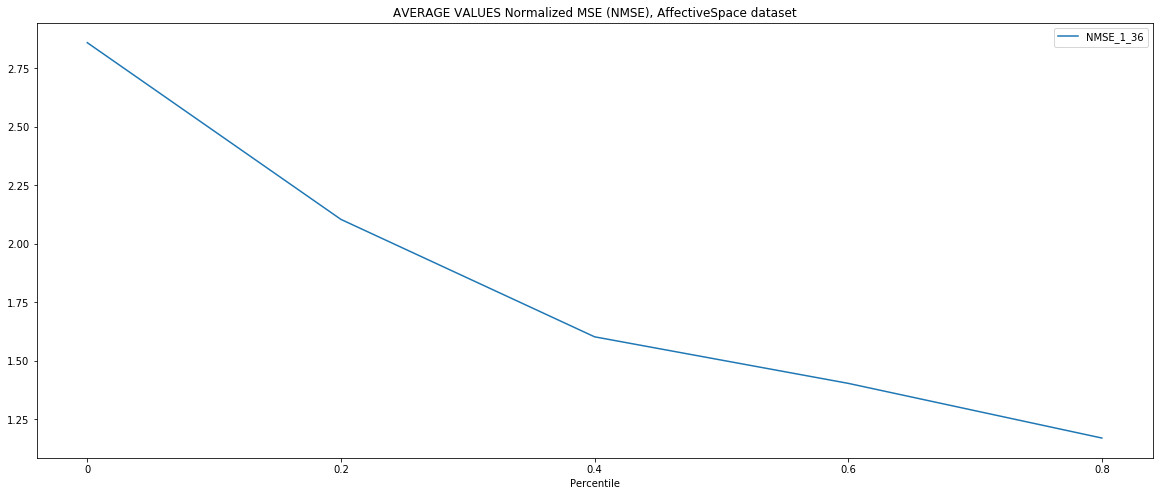

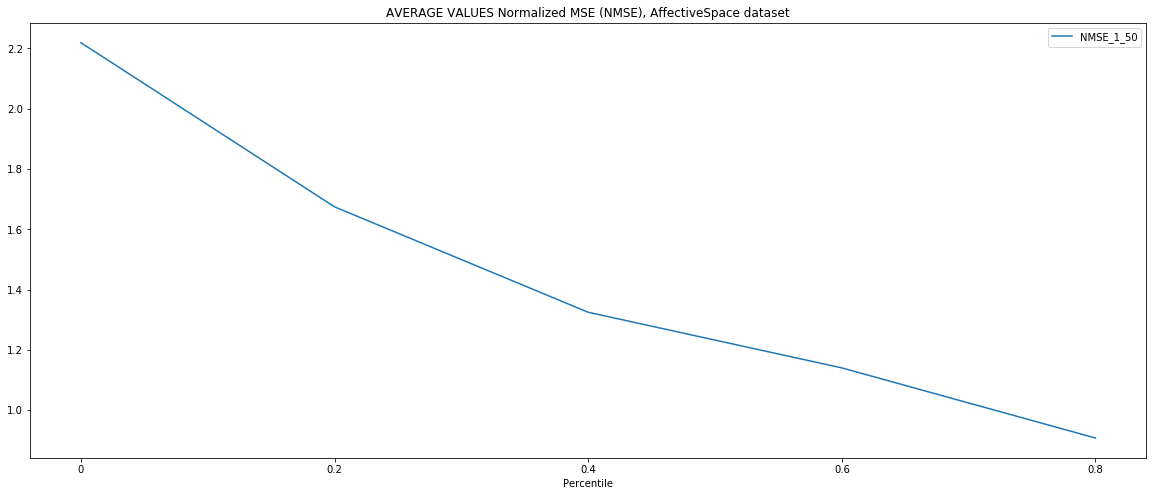

In [6]:
#Predictions Percentile on fluctuations
from sklearn.metrics import matthews_corrcoef, accuracy_score
from sklearn.metrics import mean_squared_error as MSE

def sign(vec):
    return [1 if v>0 else 0 for v in vec]

FUTURE_WINDOWs = [(1,2),(1,8),(1,29),(1,36),(1,50)]
NMSEs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
ACCs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MSEs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MCCs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MSEs_avg_weight = np.zeros([len(FUTURE_WINDOWs), 5])

for ticker in tickers:
    for (init, finish) in FUTURE_WINDOWs:
        print(ticker,' ',init,' ',finish)
        ds = DatasetManager()
        ds.load_dataset(ticker = ticker, kind = kind_of_dataset, technicalFeatures=True)
        (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
        y_pred = np.loadtxt('test_predictions/'+ticker+'_'+str(init)+'_'+str(finish)+'.csv', delimiter=",")
        
        thresholds = np.linspace(0, max(np.absolute(y_test)), num=6)[:-1]
        for t in range(0,5):
            threshold = thresholds[t]
            y_over_th = []
            y_pred_over_th = []
            weights_over_th = []
            for y, y_p, w in zip(y_test, y_pred, weights):
                if(abs(y)> threshold):
                    y_over_th.append(y)
                    y_pred_over_th.append(y_p)
                    weights_over_th.append(w)
            mse_w = MSE(y_over_th,y_pred_over_th, sample_weight = weights_over_th)
            mse = MSE(y_over_th,y_pred_over_th)
            nmse =  MSE(y_over_th,y_pred_over_th) / MSE(y_over_th,[0]*len(y_over_th))
            mcc = matthews_corrcoef(sign(y_over_th), sign(y_pred_over_th))
            acc = accuracy_score(sign(y_over_th), sign(y_pred_over_th))
            MSEs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= mse/len(tickers)
            NMSEs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= nmse/len(tickers)
            MSEs_avg_weight[FUTURE_WINDOWs.index((init, finish)), t]+= mse_w/len(tickers)
            ACCs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= acc/len(tickers)
            MCCs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= mcc/len(tickers)

    labels = [0,0.2,.4,.6,.8]
plt.figure(figsize=(20,8))
for i in range(len(FUTURE_WINDOWs)):
    plt.plot(ACCs_avg[i,:], label='ACC_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
plt.xlabel('Percentile')
plt.xticks(range(0,len(labels)), labels)
plt.title('AVERAGE VALUES ACC, '+str(kind_of_dataset)+' dataset')
plt.legend()
plt.show() 
plt.figure(figsize=(20,8))
for i in range(len(FUTURE_WINDOWs)):
    plt.plot(MCCs_avg[i,:], label='MCC_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
plt.xlabel('Percentile')
plt.xticks(range(0,len(labels)), labels)
plt.title('AVERAGE VALUES MCC, '+str(kind_of_dataset)+' dataset')
plt.legend()
plt.show() 
for i in range(len(FUTURE_WINDOWs)):
    plt.figure(figsize=(20,8)) 
    plt.plot(NMSEs_avg[i,:], label='NMSE_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
    plt.xlabel('Percentile')
    plt.xticks(range(0,len(labels)), labels)
    plt.title('AVERAGE VALUES Normalized MSE (NMSE), '+str(kind_of_dataset)+' dataset')
    plt.legend()
    plt.show() 

np.savetxt('NMSE_percentile_on_fluctuations.csv', NMSEs_avg, delimiter=",")
np.savetxt('ACC_percentile_on_fluctuations.csv', ACCs_avg, delimiter=",")
np.savetxt('MCC_percentile_on_fluctuations.csv', MCCs_avg, delimiter=",")

AAPL   1   2


/home/simone/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


AAPL   1   8
AAPL   1   29
AAPL   1   36
AAPL   1   50
AMZN   1   2
AMZN   1   8
AMZN   1   29
AMZN   1   36
AMZN   1   50
GOOGL   1   2
GOOGL   1   8
GOOGL   1   29
GOOGL   1   36
GOOGL   1   50
MSFT   1   2
MSFT   1   8
MSFT   1   29
MSFT   1   36
MSFT   1   50
FB   1   2
FB   1   8
FB   1   29
FB   1   36
FB   1   50
INTC   1   2
INTC   1   8
INTC   1   29
INTC   1   36
INTC   1   50
CSCO   1   2
CSCO   1   8
CSCO   1   29
CSCO   1   36
CSCO   1   50
CMCSA   1   2
CMCSA   1   8
CMCSA   1   29
CMCSA   1   36
CMCSA   1   50
NVDA   1   2
NVDA   1   8
NVDA   1   29
NVDA   1   36
NVDA   1   50
NFLX   1   2
NFLX   1   8
NFLX   1   29
NFLX   1   36
NFLX   1   50


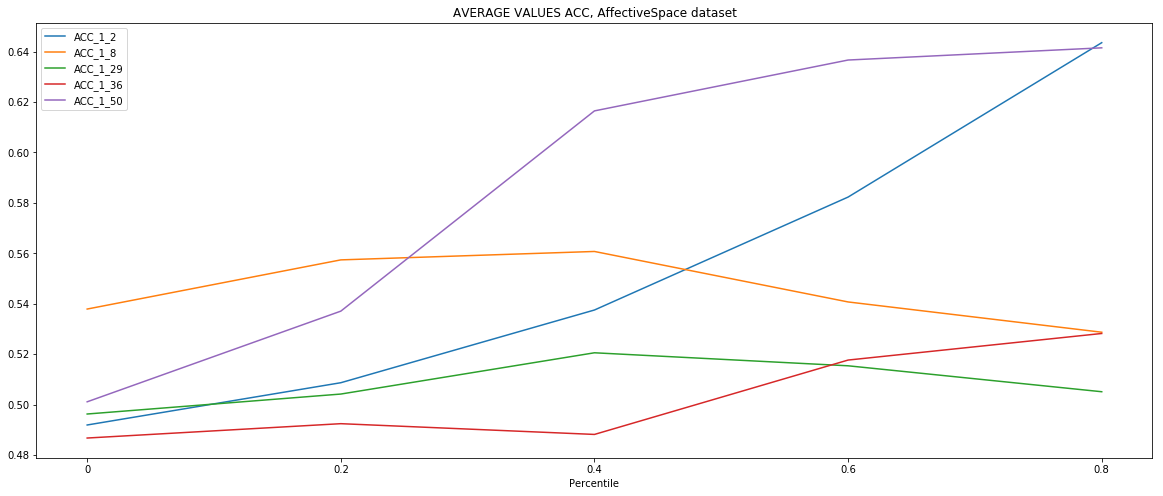

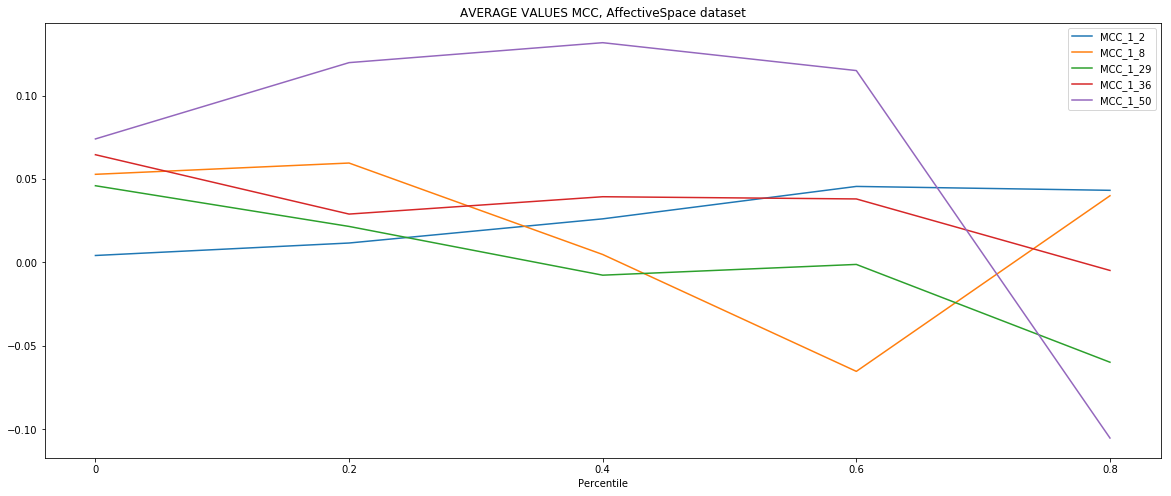

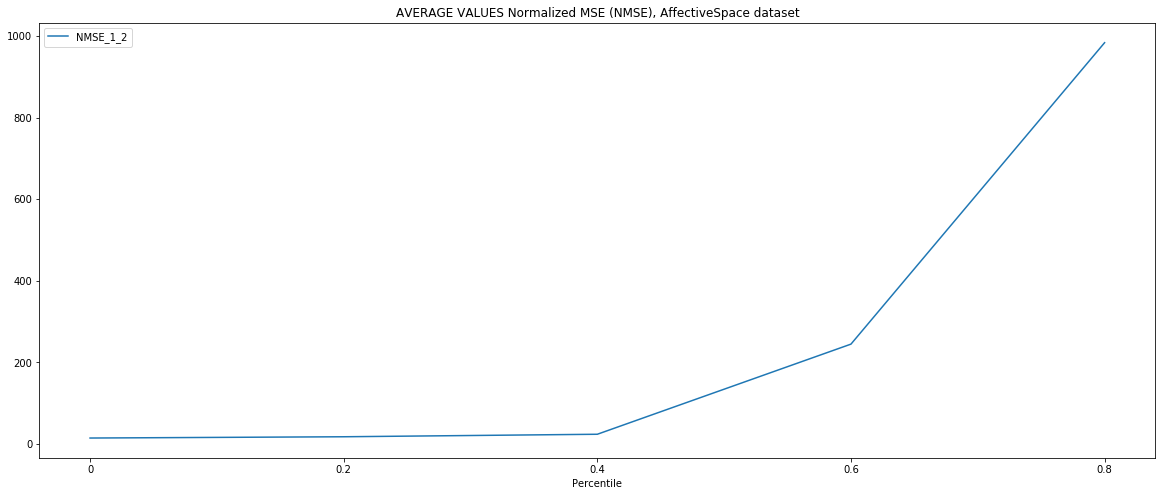

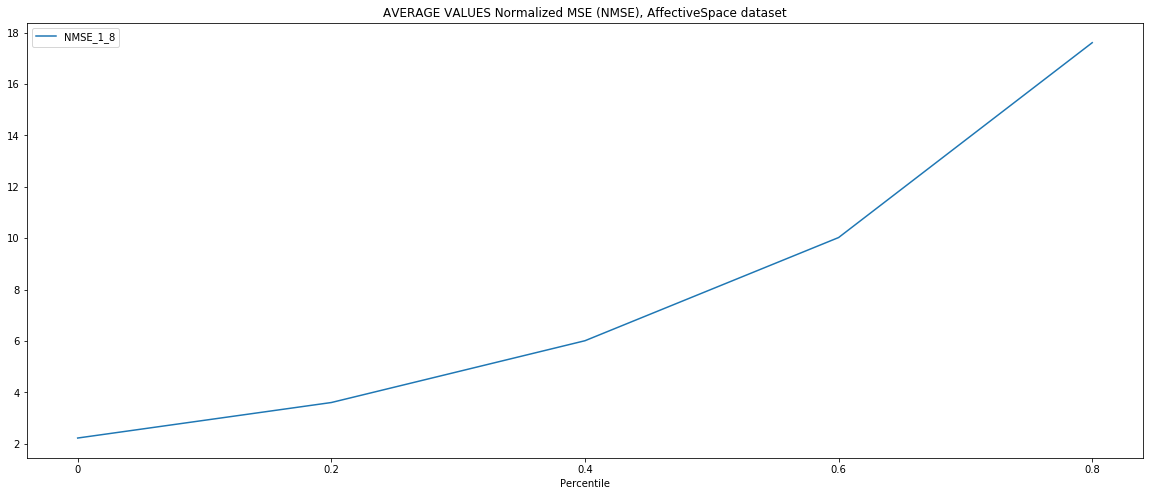

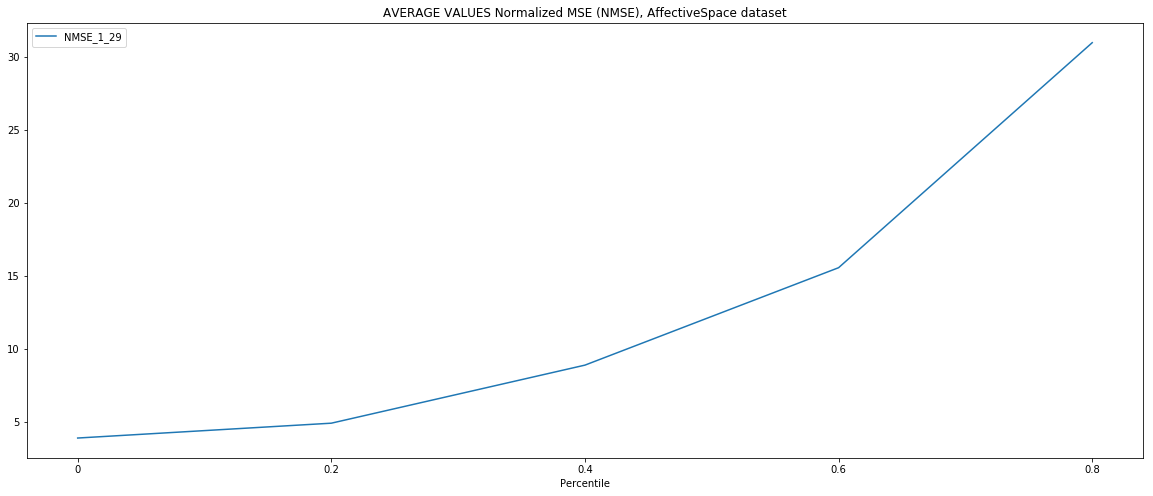

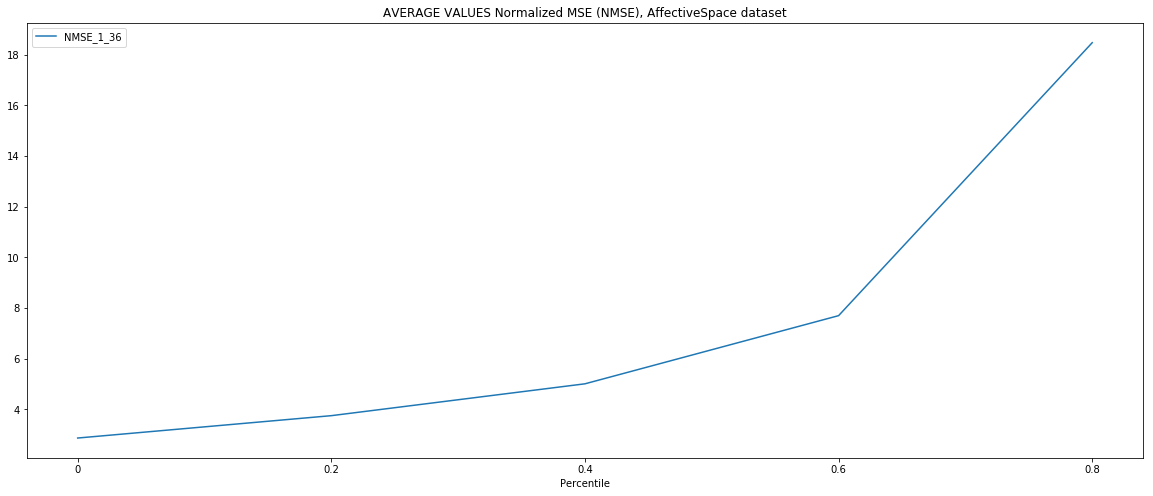

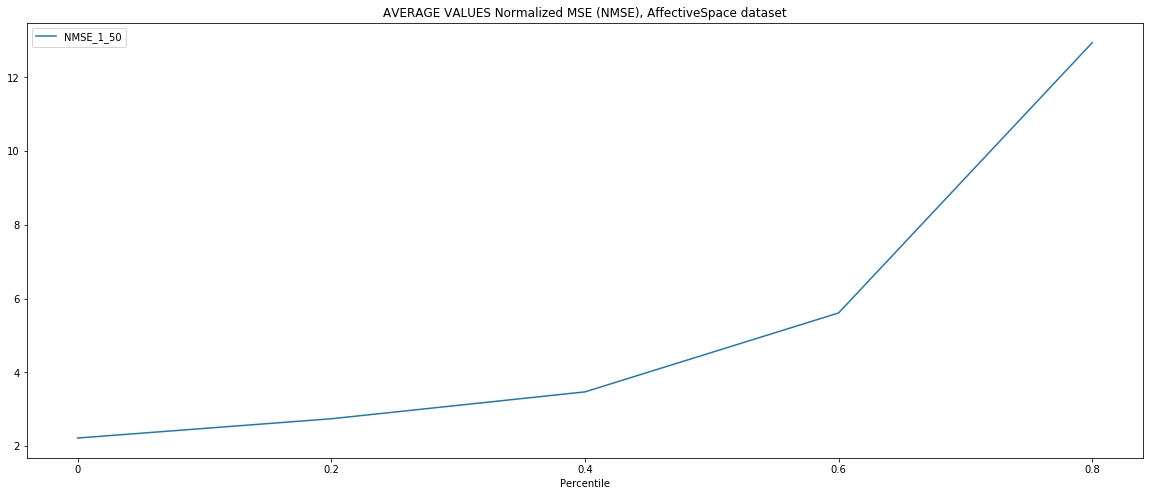

In [7]:
#Predictions percentile on predictions
from sklearn.metrics import matthews_corrcoef, accuracy_score
from sklearn.metrics import mean_squared_error as MSE

def sign(vec):
    return [1 if v>0 else 0 for v in vec]

FUTURE_WINDOWs = [(1,2),(1,8),(1,29),(1,36),(1,50)]
NMSEs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
ACCs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MSEs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MCCs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MSEs_avg_weight = np.zeros([len(FUTURE_WINDOWs), 5])

for ticker in tickers:
    for (init, finish) in FUTURE_WINDOWs:
        print(ticker,' ',init,' ',finish)
        ds = DatasetManager()
        ds.load_dataset(ticker = ticker, kind = kind_of_dataset, technicalFeatures=True)
        (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
        y_pred = np.loadtxt('test_predictions/'+ticker+'_'+str(init)+'_'+str(finish)+'.csv', delimiter=",")
        
        thresholds = np.linspace(0, max(np.absolute(y_pred)), num=6)[:-1]
        for t in range(0,5):
            threshold = thresholds[t]
            y_over_th = []
            y_pred_over_th = []
            for y, y_p in zip(y_test, y_pred):
                if(abs(y_p)> threshold):
                    y_over_th.append(y)
                    y_pred_over_th.append(y_p)
            nmse =  MSE(y_over_th,y_pred_over_th) / MSE(y_over_th,[0]*len(y_over_th))
            mcc = matthews_corrcoef(sign(y_over_th), sign(y_pred_over_th))
            acc = accuracy_score(sign(y_over_th), sign(y_pred_over_th))
            NMSEs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= nmse/len(tickers)
            ACCs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= acc/len(tickers)
            MCCs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= mcc/len(tickers)

    labels = [0,0.2,.4,.6,.8]
plt.figure(figsize=(20,8))
for i in range(len(FUTURE_WINDOWs)):
    plt.plot(ACCs_avg[i,:], label='ACC_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
plt.xlabel('Percentile')
plt.xticks(range(0,len(labels)), labels)
plt.title('AVERAGE VALUES ACC, '+str(kind_of_dataset)+' dataset')
plt.legend()
plt.show() 
plt.figure(figsize=(20,8))
for i in range(len(FUTURE_WINDOWs)):
    plt.plot(MCCs_avg[i,:], label='MCC_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
plt.xlabel('Percentile')
plt.xticks(range(0,len(labels)), labels)
plt.title('AVERAGE VALUES MCC, '+str(kind_of_dataset)+' dataset')
plt.legend()
plt.show() 
for i in range(len(FUTURE_WINDOWs)):
    plt.figure(figsize=(20,8))
    plt.plot(NMSEs_avg[i,:], label='NMSE_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
    plt.xlabel('Percentile')
    plt.xticks(range(0,len(labels)), labels)
    plt.title('AVERAGE VALUES Normalized MSE (NMSE), '+str(kind_of_dataset)+' dataset')
    plt.legend()
    plt.show() 
    

np.savetxt('NMSE_percentile_on_predictions.csv', NMSEs_avg, delimiter=",")
np.savetxt('ACC_percentile_on_predictions.csv', ACCs_avg, delimiter=",")
np.savetxt('MCC_percentile_on_predictions.csv', MCCs_avg, delimiter=",")

AAPL   1   2


/home/simone/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


AAPL   1   8
AAPL   1   29
AAPL   1   36
AAPL   1   50
AMZN   1   2
AMZN   1   8
AMZN   1   29
AMZN   1   36
AMZN   1   50
GOOGL   1   2
GOOGL   1   8
GOOGL   1   29
GOOGL   1   36
GOOGL   1   50
MSFT   1   2
MSFT   1   8
MSFT   1   29
MSFT   1   36
MSFT   1   50
FB   1   2
FB   1   8
FB   1   29
FB   1   36
FB   1   50
INTC   1   2
INTC   1   8
INTC   1   29
INTC   1   36
INTC   1   50
CSCO   1   2
CSCO   1   8
CSCO   1   29
CSCO   1   36
CSCO   1   50
CMCSA   1   2
CMCSA   1   8
CMCSA   1   29
CMCSA   1   36
CMCSA   1   50
NVDA   1   2
NVDA   1   8
NVDA   1   29
NVDA   1   36
NVDA   1   50
NFLX   1   2
NFLX   1   8
NFLX   1   29
NFLX   1   36
NFLX   1   50


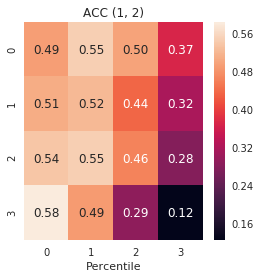

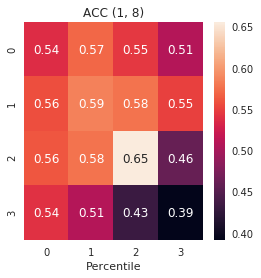

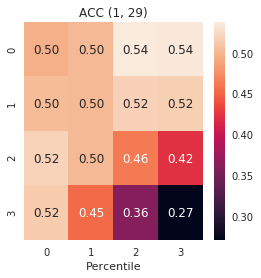

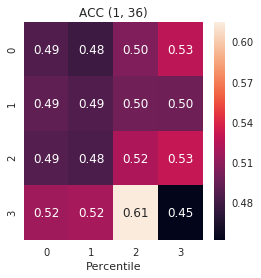

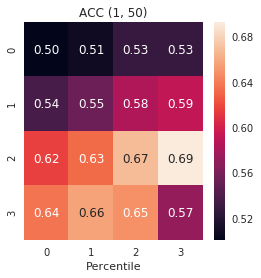

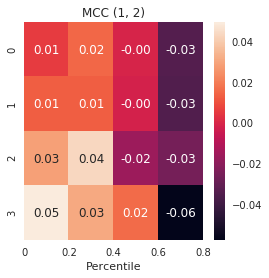

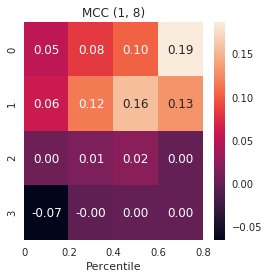

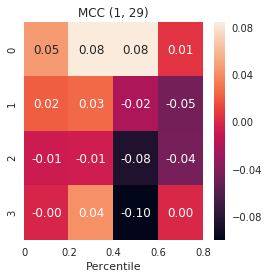

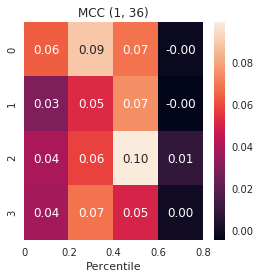

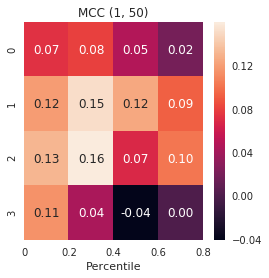

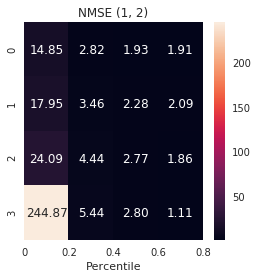

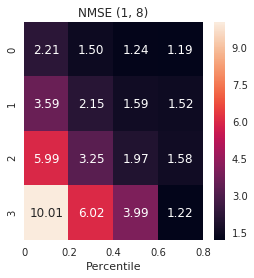

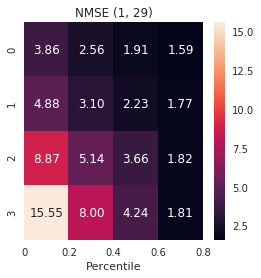

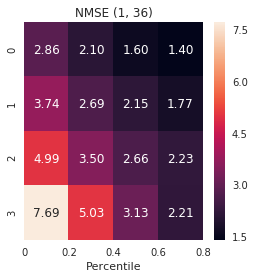

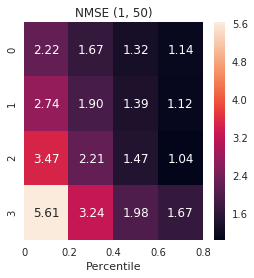

Conf matr (1, 2)
[[183.1  82.8]
 [205.3  95.8]]
Conf matr (1, 8)
[[ 68.8 190.8]
 [ 70.3 235.1]]
Conf matr (1, 29)
[[180.5  59.2]
 [222.4  96.9]]
Conf matr (1, 36)
[[188.8  44.2]
 [241.7  82.3]]
Conf matr (1, 50)
[[171.8  51.9]
 [224.  105.3]]


In [9]:
#Predictions percentile on predictions and fluctuations
import seaborn as sns; sns.set()
from sklearn.metrics import matthews_corrcoef, accuracy_score
from sklearn.metrics import mean_squared_error as MSE

def sign(vec):
    return [1 if v>0 else 0 for v in vec]

FUTURE_WINDOWs = [(1,2),(1,8),(1,29),(1,36),(1,50)]
NMSEs_avg = np.zeros([len(FUTURE_WINDOWs), 4,4])
ACCs_avg = np.zeros([len(FUTURE_WINDOWs), 4,4])
MCCs_avg = np.zeros([len(FUTURE_WINDOWs), 4,4])
CM_avg = np.zeros([len(FUTURE_WINDOWs), 2,2])



for ticker in tickers:
    for (init, finish) in FUTURE_WINDOWs:
        print(ticker,' ',init,' ',finish)
        ds = DatasetManager()
        ds.load_dataset(ticker = ticker, kind = kind_of_dataset, technicalFeatures=True)
        (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
        y_pred = np.loadtxt('test_predictions/'+ticker+'_'+str(init)+'_'+str(finish)+'.csv', delimiter=",")
        CM_avg[FUTURE_WINDOWs.index((init, finish)), :,:] +=confusion_matrix(sign(y_test),sign(y_pred))/len(tickers)
        threshPred = np.linspace(0, max(np.absolute(y_pred)), num=6)[:-2]
        threshFluct = np.linspace(0, max(np.absolute(y_test)), num=6)[:-2]
        for tP in range(0,4):
            for tF in range(0,4):
                threshP = threshPred[tP]
                threshF = threshFluct[tF]
                y_over_th = []
                y_pred_over_th = []
                for y, y_p in zip(y_test, y_pred):
                    if(abs(y_p)> threshP and abs(y)> threshF):
                        y_over_th.append(y)
                        y_pred_over_th.append(y_p)
                if(len(y_over_th)>0 and len(y_pred_over_th)>0):
                    nmse =  MSE(y_over_th,y_pred_over_th) / MSE(y_over_th,[0]*len(y_over_th))
                    mcc = matthews_corrcoef(sign(y_over_th), sign(y_pred_over_th))
                    acc = accuracy_score(sign(y_over_th), sign(y_pred_over_th))
                    NMSEs_avg[FUTURE_WINDOWs.index((init, finish)), tP,tF]+= nmse/len(tickers)
                    ACCs_avg[FUTURE_WINDOWs.index((init, finish)), tP,tF]+= acc/len(tickers)
                    MCCs_avg[FUTURE_WINDOWs.index((init, finish)), tP,tF]+= mcc/len(tickers)

labels = [0,0.2,.4,.6,.8]
for i in range(len(FUTURE_WINDOWs)):
    plt.figure(figsize=(4,4))
    sns.heatmap(ACCs_avg[i,:,:],annot=True, fmt=".2f")
    plt.xlabel('Percentile')
    plt.title('ACC '+str(FUTURE_WINDOWs[i]))
    plt.show() 

for i in range(len(FUTURE_WINDOWs)):
    plt.figure(figsize=(4,4))
    sns.heatmap(MCCs_avg[i,:,:],annot=True, fmt=".2f")
    plt.xlabel('Percentile')
    plt.xticks(range(0,len(labels)), labels)
    plt.title('MCC '+str(FUTURE_WINDOWs[i]))
    plt.show() 
for i in range(len(FUTURE_WINDOWs)):
    plt.figure(figsize=(4,4))
    sns.heatmap(NMSEs_avg[i,:,:],annot=True, fmt=".2f")    
    plt.xlabel('Percentile')
    plt.xticks(range(0,len(labels)), labels)
    plt.title('NMSE '+str(FUTURE_WINDOWs[i]))
    plt.show() 
for i in range(len(FUTURE_WINDOWs)):
    print('Conf matr '+str(FUTURE_WINDOWs[i]))
    print(CM_avg[i,:,:])